In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.cuda.manual_seed_all(0)
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)


In [3]:
path_tr='/content/drive/MyDrive/zonenet/input_data/file_tr.csv'
path_val='/content/drive/MyDrive/zonenet/input_data/file_val.csv'
path_tst='/content/drive/MyDrive/zonenet/input_data/file_tst.csv'

EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
df_tr = pd.read_csv(path_tr)
df_val = pd.read_csv(path_val)
df_tst = pd.read_csv(path_tst)
print(df_tr.shape)
df_tr.head(2)

(334, 20)


,timestep,firing_rates,setpoints,flowpattern,q_enthalpy,tG_gaszone,tS_furnace,tS_obstacle,w_flux_furnace,w_flux_obstacle,nodetmp_1d_furnace,nodetmp_2d_obstacle,corrcoeff_b,Qconvi,extinctioncoeff_k,gasvolumes_Vi,QfuelQa_sum,surfareas_Ai,emissivity_epsi,convection_flux_qconvi
0,1005015,"[0.0, 0.9, 0.507]","[1228.0, 1493.0, 1523.0]","[0.24408, 0.00033, 0.0, 0.0, 0.09992, 0.00668,...","[264659.625, 5701.172, 15046.516, 18962.078, 2...","[1154.929, 667.527, 683.451, 735.837, 801.661,...","[937.438, 727.792, 711.038, 746.487, 804.916, ...","[53.419, 40.889, 36.936, 39.988, 42.808, 42.80...","[-4385.452, -822.878, -445.388, -601.827, -861...","[38961.855, 20849.539, 93180.945, 80582.922, 8...","[937.438, 710.18, 491.902, 273.783, 55.564, 72...","[59.838, 31.739, 30.059, 30.965, 47.338, 50.19...","[0.717, -0.231, 0.459, -0.078, 0.12, 0.013, -0...","[105589.953, 13229.063, 11730.326, 12516.344, ...","[0.035, 0.178, 0.625, 0.768, 25.748, 25.891]","[0.61, 0.581, 0.458, 0.458, 0.447, 0.681, 0.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.325, 0.312, 0.256, 0.256, 0.251, 0.388, 0.4...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[-4385.452, -822.878, -445.388, -601.827, -861..."
1,1005030,"[0.0, 0.9, 0.5]","[1228.0, 1493.0, 1523.0]","[0.24301, 0.00024, 0.0, 0.0, 0.09915, 0.00668,...","[262802.844, 5816.25, 15003.266, 18859.625, 22...","[1153.639, 666.38, 683.088, 735.567, 801.377, ...","[934.249, 727.015, 710.496, 745.808, 803.988, ...","[79.299, 57.298, 52.079, 57.967, 61.661, 61.66...","[-4201.41, -859.177, -456.041, -597.59, -841.8...","[38426.961, 20458.959, 91917.609, 79642.922, 8...","[934.249, 710.183, 491.902, 273.783, 55.564, 7...","[91.591, 45.583, 40.079, 42.927, 69.655, 73.21...","[0.717, -0.231, 0.459, -0.078, 0.12, 0.013, -0...","[103801.781, 13327.563, 11663.066, 12396.148, ...","[0.035, 0.178, 0.625, 0.768, 25.748, 25.891]","[0.61, 0.581, 0.458, 0.458, 0.447, 0.681, 0.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.325, 0.312, 0.256, 0.256, 0.251, 0.388, 0.4...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[-4201.41, -859.177, -456.041, -597.59, -841.8..."


In [5]:


def get_field_matrix(reqfield,df):
    for i in range(1,df.shape[0]):
        if i==1:
            tmp=eval(df.loc[i,reqfield])
            X=np.vstack([eval(df.loc[0,reqfield]),tmp])
        else:
            tmp=eval(df.loc[i,reqfield])
            X=np.vstack([X,tmp])
    print(X.shape)
    # print(X)
    return X

Xtr_fr=get_field_matrix('firing_rates',df_tr)
ytr_tG=get_field_matrix('tG_gaszone',df_tr)
ytr_tS_fur=get_field_matrix('tS_furnace',df_tr)
ytr_tS_obs=get_field_matrix('tS_obstacle',df_tr)

Xtr=Xtr_fr
ytr=np.hstack([ytr_tG,ytr_tS_fur,ytr_tS_obs])
# print(Xtr.shape)
# print(ytr.shape)

(334, 3)
(334, 24)
(334, 76)
(334, 102)


In [6]:
Xval_fr=get_field_matrix('firing_rates',df_val)
yval_tG=get_field_matrix('tG_gaszone',df_val)
yval_tS_fur=get_field_matrix('tS_furnace',df_val)
yval_tS_obs=get_field_matrix('tS_obstacle',df_val)

Xval=Xval_fr
yval=np.hstack([yval_tG,yval_tS_fur,yval_tS_obs])

Xtst_fr=get_field_matrix('firing_rates',df_tst)
ytst_tG=get_field_matrix('tG_gaszone',df_tst)
ytst_tS_fur=get_field_matrix('tS_furnace',df_tst)
ytst_tS_obs=get_field_matrix('tS_obstacle',df_tst)

Xtst=Xtst_fr
ytst=np.hstack([ytst_tG,ytst_tS_fur,ytst_tS_obs])

(334, 3)
(334, 24)
(334, 76)
(334, 102)
(334, 3)
(334, 24)
(334, 76)
(334, 102)


In [7]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).float())
val_dataset = RegressionDataset(torch.from_numpy(Xval).float(), torch.from_numpy(yval).float())
test_dataset = RegressionDataset(torch.from_numpy(Xtst).float(), torch.from_numpy(ytst).float())

In [8]:
NUM_FEATURES = Xtr.shape[1]
NUM_OUTPUTS = ytr.shape[1]
print(NUM_FEATURES,NUM_OUTPUTS)

3 202


In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [10]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features,num_outputs):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 12)
        self.layer_2 = nn.Linear(12, 96)
        self.layer_out = nn.Linear(96, num_outputs)
        
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = MultipleRegression(NUM_FEATURES,NUM_OUTPUTS)
model.to(device)

# print(model)


cpu


MultipleRegression(
  (layer_1): Linear(in_features=3, out_features=12, bias=True)
  (layer_2): Linear(in_features=12, out_features=96, bias=True)
  (layer_out): Linear(in_features=96, out_features=202, bias=True)
  (relu): ReLU()
)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
loss_stats = {
    'train': [],
    "val": []
}

In [14]:
# ## DUMMY debugging code

# for i in range(1, 100, 2):
#     dx_train = torch.tensor([i, i + 1]).reshape(2, 1).float()
#     dy_train = torch.tensor([[j, 2 * j, 3 * j] for j in dx_train]).float()
# print(dx_train.size(),dy_train.size())

# class MultiOutputRegression(torch.nn.Module):

#     def __init__(self):
#         super(MultiOutputRegression, self).__init__()
#         self.linear1 = torch.nn.Linear(1, 10)
#         self.linear2 = torch.nn.Linear(10, 10)
#         self.linear3 = torch.nn.Linear(10, 3)

#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.linear2(x)
#         x = self.linear3(x)
#         return x

# model = MultiOutputRegression()

# dy_pred = model(dx_train)
# loss = criterion(dy_pred, dy_train)

# print(dy_pred.size(),loss)

# # torch.Size([2, 1]) torch.Size([2, 3])
# # torch.Size([2, 3]) tensor(47914.6992, grad_fn=<MseLossBackward0>)

In [15]:
# # ## DUMMY debugging code
# X_train_batch, y_train_batch=next(iter(train_loader))
# print(X_train_batch.size(),y_train_batch.size())
# # torch.Size([64, 3]) torch.Size([64, 202])

In [16]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 962182.59375 | Val Loss: 963507.75225
Epoch 002: | Train Loss: 963046.00000 | Val Loss: 963358.40494
Epoch 003: | Train Loss: 962655.57292 | Val Loss: 963183.21351
Epoch 004: | Train Loss: 961596.02083 | Val Loss: 962975.50412
Epoch 005: | Train Loss: 962473.67708 | Val Loss: 962729.00674
Epoch 006: | Train Loss: 961969.07292 | Val Loss: 962436.06475
Epoch 007: | Train Loss: 960819.76042 | Val Loss: 962087.71931
Epoch 008: | Train Loss: 960914.57292 | Val Loss: 961673.74401
Epoch 009: | Train Loss: 960628.52083 | Val Loss: 961182.89484
Epoch 010: | Train Loss: 959990.48958 | Val Loss: 960602.69293
Epoch 011: | Train Loss: 959796.83333 | Val Loss: 959920.40326
Epoch 012: | Train Loss: 958844.88542 | Val Loss: 959121.85423
Epoch 013: | Train Loss: 958570.19792 | Val Loss: 958192.79304
Epoch 014: | Train Loss: 957298.13542 | Val Loss: 957117.89427
Epoch 015: | Train Loss: 956149.06250 | Val Loss: 955882.05782
Epoch 016: | Train Loss: 954340.98958 | Val Loss: 95446

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

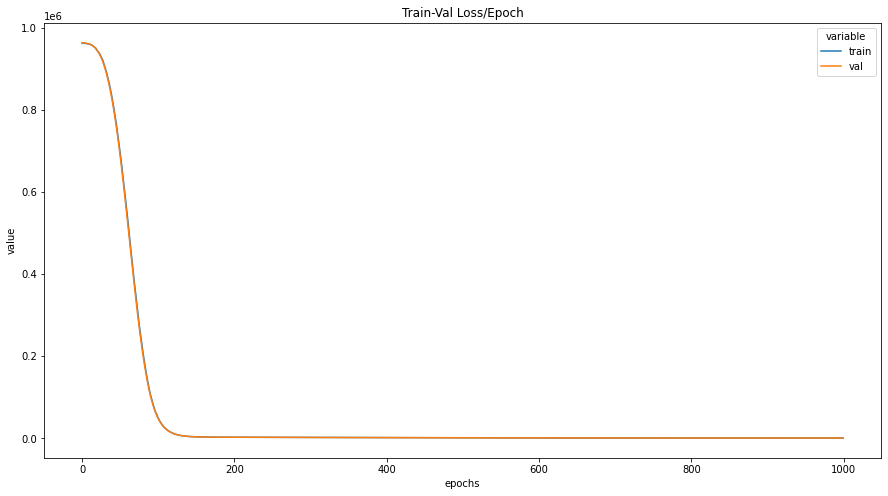

In [17]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [18]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        # print(y_test_pred.size())
        y_pred_list.append(y_test_pred.cpu().numpy())

for i in range(1,len(y_pred_list)):
    if i==1:
        ytst_pred_mat=np.vstack([y_pred_list[0],y_pred_list[i]])
    else:
        ytst_pred_mat=np.vstack([ytst_pred_mat,y_pred_list[i]])
print(ytst_pred_mat.shape)
print('predicted temperatures:')
print(ytst_pred_mat)
print('actual temperatures:')
print(ytst)



(334, 202)
predicted temperatures:
[[1246.6436   681.0439   699.9302  ... 1242.568   1227.6239  1227.6238 ]
 [1247.2084   681.3505   700.24646 ... 1243.1318  1228.1794  1228.1794 ]
 [1247.8524   681.70044  700.60724 ... 1243.7747  1228.813   1228.8131 ]
 ...
 [1243.5048   679.3438   698.17395 ... 1239.4326  1224.5385  1224.5376 ]
 [1243.019    679.08044  697.9021  ... 1238.9478  1224.0609  1224.06   ]
 [1241.6509   678.3342   697.13464 ... 1237.5835  1222.7139  1222.7128 ]]
actual temperatures:
[[1237.423  672.911  693.352 ... 1241.645 1226.427 1226.427]
 [1246.21   674.296  694.828 ... 1241.538 1226.456 1226.456]
 [1254.604  675.706  696.32  ... 1241.444 1226.493 1226.493]
 ...
 [1231.15   692.075  707.629 ... 1242.182 1229.396 1229.396]
 [1223.908  692.041  707.513 ... 1245.103 1226.414 1226.414]
 [1154.928  667.527  683.451 ... 1244.918 1226.488 1226.488]]


In [19]:
mse_list=[]
for jj in range(ytst_pred_mat.shape[1]):
    mse_list.append(mean_squared_error(ytst[:,jj], ytst_pred_mat[:,jj]))
mse_list_tG=mse_list[:ytr_tG.shape[1]]
mse_list_tS_fur=mse_list[ytr_tG.shape[1]:ytr_tG.shape[1]+ytr_tS_fur.shape[1]]
mse_list_tS_obs=mse_list[ytr_tG.shape[1]+ytr_tS_fur.shape[1]:]

print('mse_avg_tG:',sum(mse_list_tG)/len(mse_list_tG))
print('mse_avg_tS_fur:',sum(mse_list_tS_fur)/len(mse_list_tS_fur))
print('mse_avg_tS_obs:',sum(mse_list_tS_obs)/len(mse_list_tS_obs))
print('mse_avg:',sum(mse_list)/len(mse_list))

mae_list=[]
for jj in range(ytst_pred_mat.shape[1]):
    mae_list.append(mean_absolute_error(ytst[:,jj], ytst_pred_mat[:,jj]))
mae_list_tG=mae_list[:ytr_tG.shape[1]]
mae_list_tS_fur=mae_list[ytr_tG.shape[1]:ytr_tG.shape[1]+ytr_tS_fur.shape[1]]
mae_list_tS_obs=mae_list[ytr_tG.shape[1]+ytr_tS_fur.shape[1]:]

print('mae_avg_tG:',sum(mae_list_tG)/len(mae_list_tG))
print('mae_avg_tS_fur:',sum(mae_list_tS_fur)/len(mae_list_tS_fur))
print('mae_avg_tS_obs:',sum(mae_list_tS_obs)/len(mae_list_tS_obs))
print('mae_avg:',sum(mae_list)/len(mae_list))

r2_list=[]
for jj in range(ytst_pred_mat.shape[1]):
    r2_list.append(r2_score(ytst[:,jj], ytst_pred_mat[:,jj]))
r2_list_tG=r2_list[:ytr_tG.shape[1]]
r2_list_tS_fur=r2_list[ytr_tG.shape[1]:ytr_tG.shape[1]+ytr_tS_fur.shape[1]]
r2_list_tS_obs=r2_list[ytr_tG.shape[1]+ytr_tS_fur.shape[1]:]

print('r2_avg_tG:',sum(r2_list_tG)/len(r2_list_tG))
print('r2_avg_tS_fur:',sum(r2_list_tS_fur)/len(r2_list_tS_fur))
print('r2_avg_tS_obs:',sum(r2_list_tS_obs)/len(r2_list_tS_obs))
print('r2_avg:',sum(r2_list)/len(r2_list))

mse_avg_tG: 197.46191038925437
mse_avg_tS_fur: 54.46332074012627
mse_avg_tS_obs: 1216.3637589297484
mse_avg: 658.1554536456742
mae_avg_tG: 9.16595503402375
mae_avg_tS_fur: 6.411214404500774
mae_avg_tS_obs: 16.657057848665332
mae_avg: 11.91215404021036
r2_avg_tG: -1.0352920570545139
r2_avg_tS_fur: -6.626706784096423
r2_avg_tS_obs: -2.5242754600452226
r2_avg: -3.8908555538873713
